# Lab 1: Experiment Tracking
## Exercise 6: Report bad images

We want to add some examples of badly predicted images. These might come in handy later when debugging our neural network. Find 10 images where the predicted label is wrong and report them using `Logger.report_image()`

https://clear.ml/docs/latest/docs/references/sdk/logger/#report_image

You can find these bad images in ClearML under Experiment > DEBUG SAMPLES.

In [1]:
import os
from dotenv import load_dotenv

# %pip install -q scikit-learn


%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml

load_dotenv()

CLEARML_API_ACCESS_KEY=os.getenv("CLEARML_API_ACCESS_KEY")
CLEARML_API_SECRET_KEY=os.getenv("CLEARML_API_SECRET_KEY")

if CLEARML_API_ACCESS_KEY is None:
    raise KeyError("CLEARML_API_ACCESS_KEY")

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml


ClearML Task: created new task id=4146f639b70a44bb9371a5638330e149
2024-06-03 13:55:28,032 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/156920b4140a41ed894eba6f84846cb0/experiments/4146f639b70a44bb9371a5638330e149/output/log
Class names: ['bird', 'cat', 'deer', 'dog']
Number of train images: 16000
Number of test images: 4000
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3014 - loss: 1.3604 - val_accuracy: 0.3927 - val_loss: 1.2737
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4159 - loss: 1.2238 - val_accuracy: 0.4675 - val_loss: 1.1697
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4806 - loss: 1.1483 - val_accuracy: 0.5063 - val_loss: 1.1365
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5032 - loss: 1.1166 - val_accuracy: 0.5038 - val_loss: 1.1175
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5217 - loss: 1.0866 - 

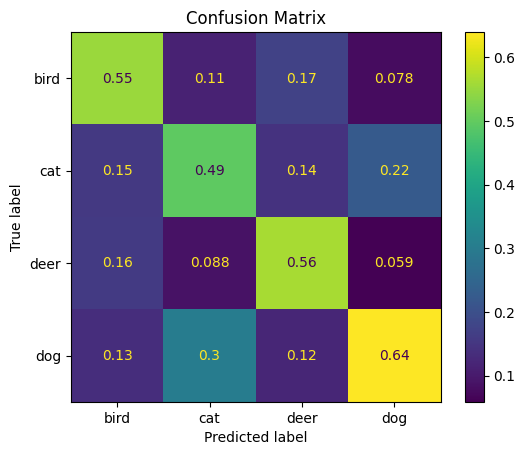

In [2]:
import tensorflow.keras as keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from clearml import Task, Logger
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

task = Task.init(project_name='vives-mlops-workshop', task_name='exercise6', output_uri=True)

# hyperparameters
config = {
    "conv1": 4,
    "conv2": 8,
    "conv3": 8,
    "dense1": 16,
}
task.connect(config)

# ---

# download the dataset
(images, labels), _ = keras.datasets.cifar10.load_data()

# there are 10 classes of images
all_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# choose four classes (feel free to change this!)
class_names = ["bird", "cat", "deer", "dog"]
print("Class names:", class_names)

# only keep images of these classes
class_indexes = [all_classes.index(c) for c in class_names]
to_keep = np.array([l in class_indexes for l in labels])
images = images[to_keep]
labels = labels[to_keep]

# change indexes from 10 to 2 classes
labels = np.array([class_indexes.index(l) for l in labels])

# normalize pixels between 0 and 1
images = images / 255.0

# split into train and test set
split = round(len(images) * 0.8)
train_images = images[:split]
train_labels = labels[:split]
test_images = images[split:]
test_labels = labels[split:]
print("Number of train images:", len(train_images))
print("Number of test images:", len(test_images))

# ---

# create neural network
model = keras.models.Sequential()
model.add(keras.Input(shape=(32, 32, 3)))

# convolutional layers
model.add(layers.Conv2D(config["conv1"], (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(config["conv2"], (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(config["conv3"], (3, 3), activation="relu"))

# add dense layers
model.add(layers.Flatten())
model.add(layers.Dense(config["dense1"], activation="relu"))
model.add(layers.Dense(4, activation="softmax"))

# ---

# compile and train the model
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))

# ---

# report accuracy to ClearML
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
logger = Logger.current_logger()

for i in range(len(accuracy)):
    logger.report_scalar("training", "accuracy", accuracy[i], iteration=i)
    logger.report_scalar("training", "val_accuracy", val_accuracy[i], iteration=i)

# save model to disk
model.save("model.keras")

# show confusion matrix
test_predict = model.predict(test_images)
test_predict = np.argmax(test_predict, axis=1)
cm = confusion_matrix(test_labels, test_predict, normalize='pred')
ConfusionMatrixDisplay(cm, display_labels=class_names).plot()
plt.title("Confusion Matrix")
plt.show()

# TODO report bad images
reported = 0
for i in range(len(test_labels)):
    if test_labels[i] != test_predict[i]:
        actual_class = class_names[test_labels[i]]
        predict_class = class_names[test_predict[i]]
        description = actual_class + " => " + predict_class
        logger.report_image(title=f"mislabeled {actual_class}(s)",series=description,image=test_images[i])
        reported += 1
        if reported >= 10:
            break

# close ClearML task
task.close()